In [1]:
import sys

sys.path.insert(1, 'C:/Users/peter/Desktop/volatility-forecasting/midas')

from volatility import MGARCH
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import time

Engle, R., Ghysels, E., and Sohn, B., 2009, "Stock Market Volatility and Macroeconomic Fundamentals" cikkben lévő 2.1-es fejezetben leírt modell alapján készült a kód. Először szimuláltam adatokat, ezt követően visszabecsültem a modellel. Legvégül valós adatokkal is lefutattam a modellt.

In [2]:
model = MGARCH()

rv_sim, tau_sim, g_sim, sigma2_sim, y_sim = model.simulate()

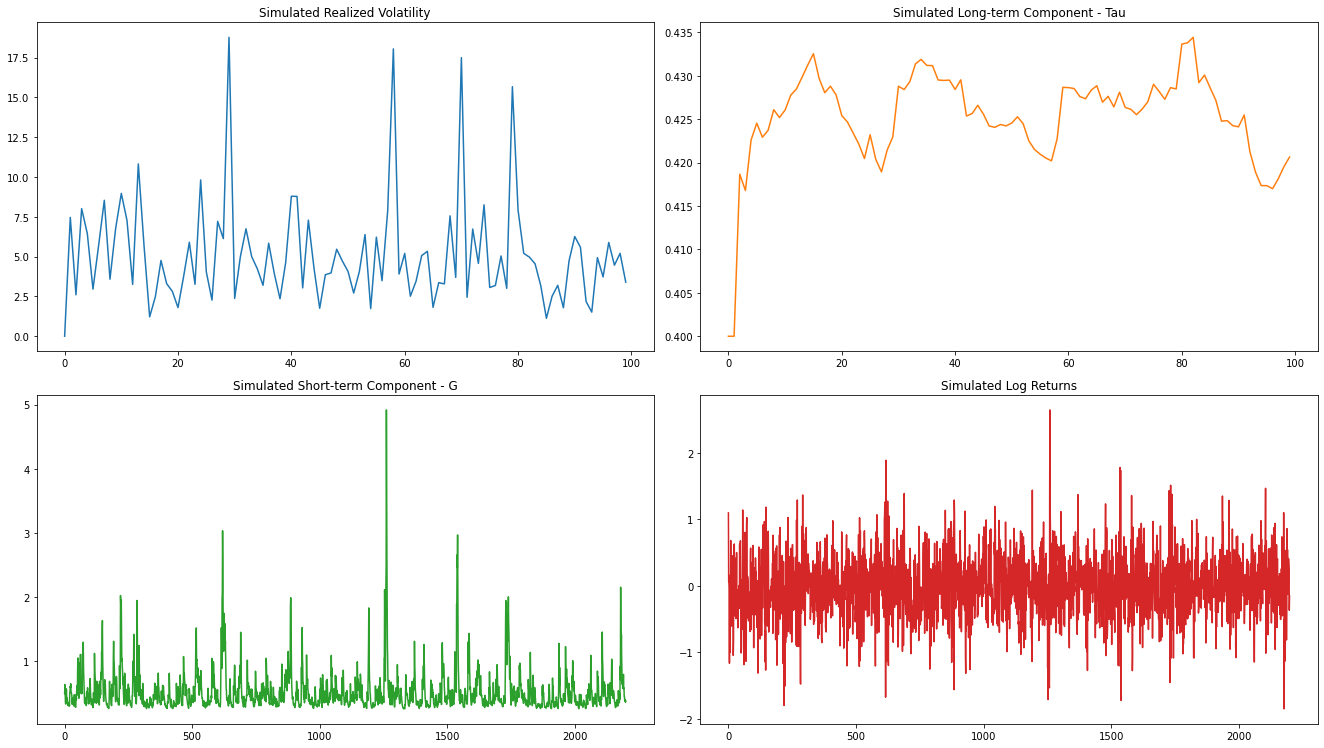

In [3]:
fig, axs = plt.subplots(2, 2)
fig.set_size_inches(18.5, 10.5)
axs[0, 0].plot(rv_sim)
axs[0, 0].set_title('Simulated Realized Volatility')
axs[0, 1].plot(tau_sim, 'tab:orange')
axs[0, 1].set_title('Simulated Long-term Component - Tau')
axs[1, 0].plot(g_sim, 'tab:green')
axs[1, 0].set_title('Simulated Short-term Component - G')
axs[1, 1].plot(y_sim, 'tab:red')
axs[1, 1].set_title('Simulated Log Returns')
fig.tight_layout()

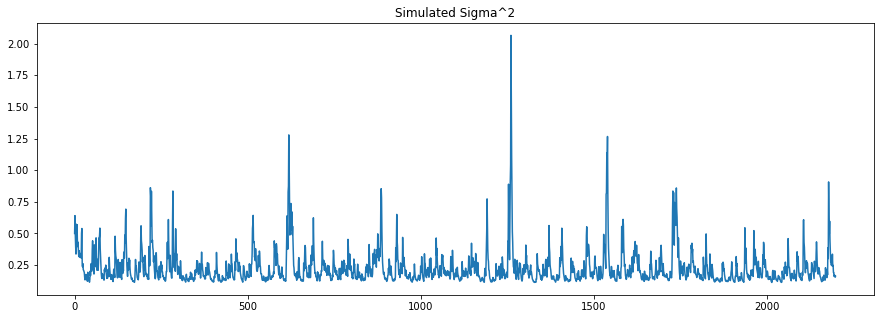

In [4]:
plt.figure(figsize=(15, 5))
plt.plot(sigma2_sim)
plt.title('Simulated Sigma^2')
plt.show()

In [5]:
month = []

for i in range(101):
    month.append(i % 12)

j = 0
m_dates = []

for i in month:
    if i == 0:
        j += 1
        m_dates.append(datetime(2010 + j, 1, 1))
    else:
        m_dates.append(datetime(2010 + j, 1 + i, 1))
        
y_dates = []
for i in m_dates[:-1]:
    for j in range(22):
        y_dates.append(i + timedelta(j))

In [6]:
X_test = pd.DataFrame(data = {'RV': rv_sim}, index = m_dates[1:])
y_test = pd.Series(y_sim, index = y_dates)

A szimulációban megadott paraméterek a következők voltak (amiket default-nak deklaráltam):<br>
[0.0, 0.1, 0.2, 0.6, 0.4, 0.005, 1.0]

In [7]:
rest = np.array(['', 'pos', 'pos', 'pos', 'pos', 'pos', 'pos'])

start = time.time()
model.fit(rest, X_test, y_test)
print(time.time() - start, 'ms to run')

Loglikelihood:  0.6395484448706963 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0   -0.004867        0.048253     -0.099442       0.089708
1    0.091412        1.785825     -3.408740       3.591564
2    0.226115        0.695214     -1.136480       1.588710
3    0.600383        0.628127     -0.630723       1.831489
4    0.383197        0.988910     -1.555032       2.321425
5    0.012146        6.193129    -12.126164      12.150456
6    0.825817        2.184651     -3.456020       5.107654
42.835469484329224 ms to run


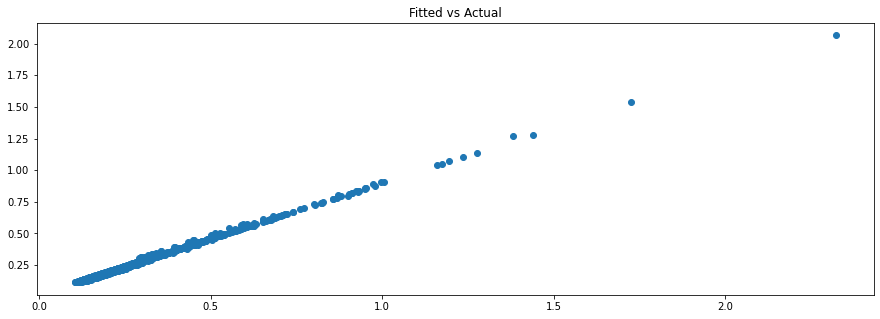

In [8]:
fit = model.predict(X_test, y_test)

plt.figure(figsize=(15, 5))
plt.scatter(fit, sigma2_sim)
plt.title('Fitted vs Actual')
plt.show()

### Valós adatokkal:

In [9]:
df = pd.read_csv('C:/Users/peter/Desktop/volatility-forecasting/data/stocks/AAPL.csv')
df = df[1508:-1469]
df.Date = df.Date.astype('datetime64[ms]')
df['LogRet'] = np.log(df.Close).diff().fillna(0.0) * 100
df.LogRet.iloc[np.where(df.LogRet.values == 0.0)[0]] = 1e-6
df['Volatility'] = df.LogRet ** 2
df = df.iloc[1:, :]
df.set_index(df.Date, inplace = True, drop = True)

per = df.index.to_period('M')
uniq = np.asarray(per.unique())

RV = np.zeros(len(uniq))
date_month = []

for t in range(len(uniq)):
    if t != len(uniq) - 1:
        plc = np.where((per  >= uniq[t].strftime('%Y-%m')) & (per < uniq[t + 1].strftime('%Y-%m')))
    else:
        plc = np.where(per  >= uniq[t].strftime('%Y-%m'))
    
    date_month.append(uniq[t].to_timestamp('M') + timedelta(1))
    monthly_rv = np.sum(df.Volatility[plc[0]].values)
    RV[t] = monthly_rv
    
RV_df = pd.DataFrame(data = {'RV': RV}, index = date_month)

y = df.LogRet 
X = RV_df

C:\Users\peter\anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [10]:
start = time.time()
model.fit(rest, X, y)
print(time.time() - start, 'ms to run')

Loglikelihood:  2.1028453069123976 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.195967        0.176751     -0.150457       0.542392
1    0.185504        2.832933     -5.366942       5.737949
2    0.087578        1.011881     -1.895673       2.070829
3    0.881436        0.282687      0.327381       1.435492
4    0.475766        4.006251     -7.376342       8.327875
5    0.003187        3.731439     -7.310298       7.316672
6    1.176801        4.006918     -6.676614       9.030216
84.46464991569519 ms to run


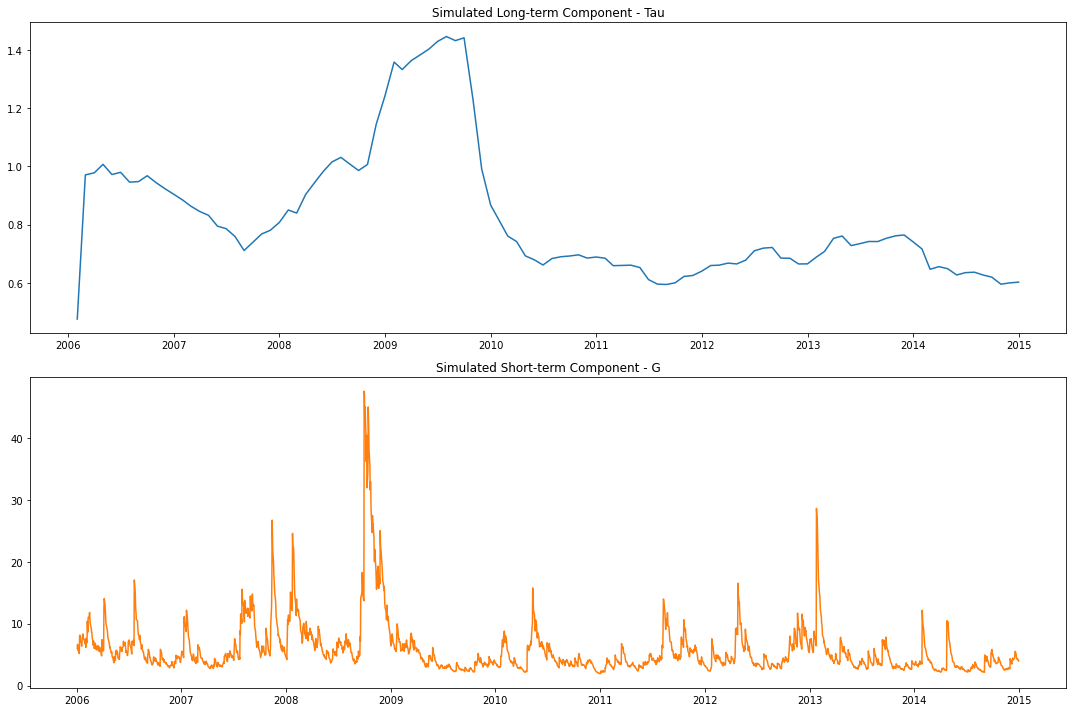

In [11]:
fig, axs = plt.subplots(2)
fig.set_size_inches(15, 10)
axs[0].plot(X.index, model.tau)
axs[0].set_title('Simulated Long-term Component - Tau')
axs[1].plot(y.index, model.g, 'tab:orange')
axs[1].set_title('Simulated Short-term Component - G')
fig.tight_layout()

In [12]:
fitted = model.predict(X, y)

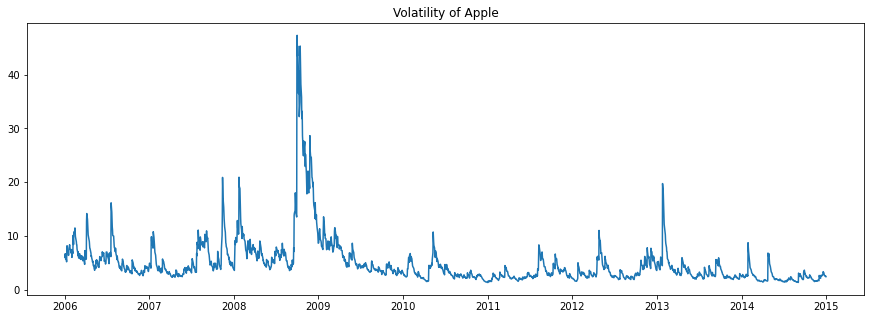

In [13]:
plt.figure(figsize=(15, 5))
plt.plot(y.index, fitted)
plt.title('Volatility of Apple')
plt.show()

In [3]:
gm_sim = pd.read_csv('C:/Users/peter/Desktop/volatility-forecasting/results/gm_sim_500.csv')

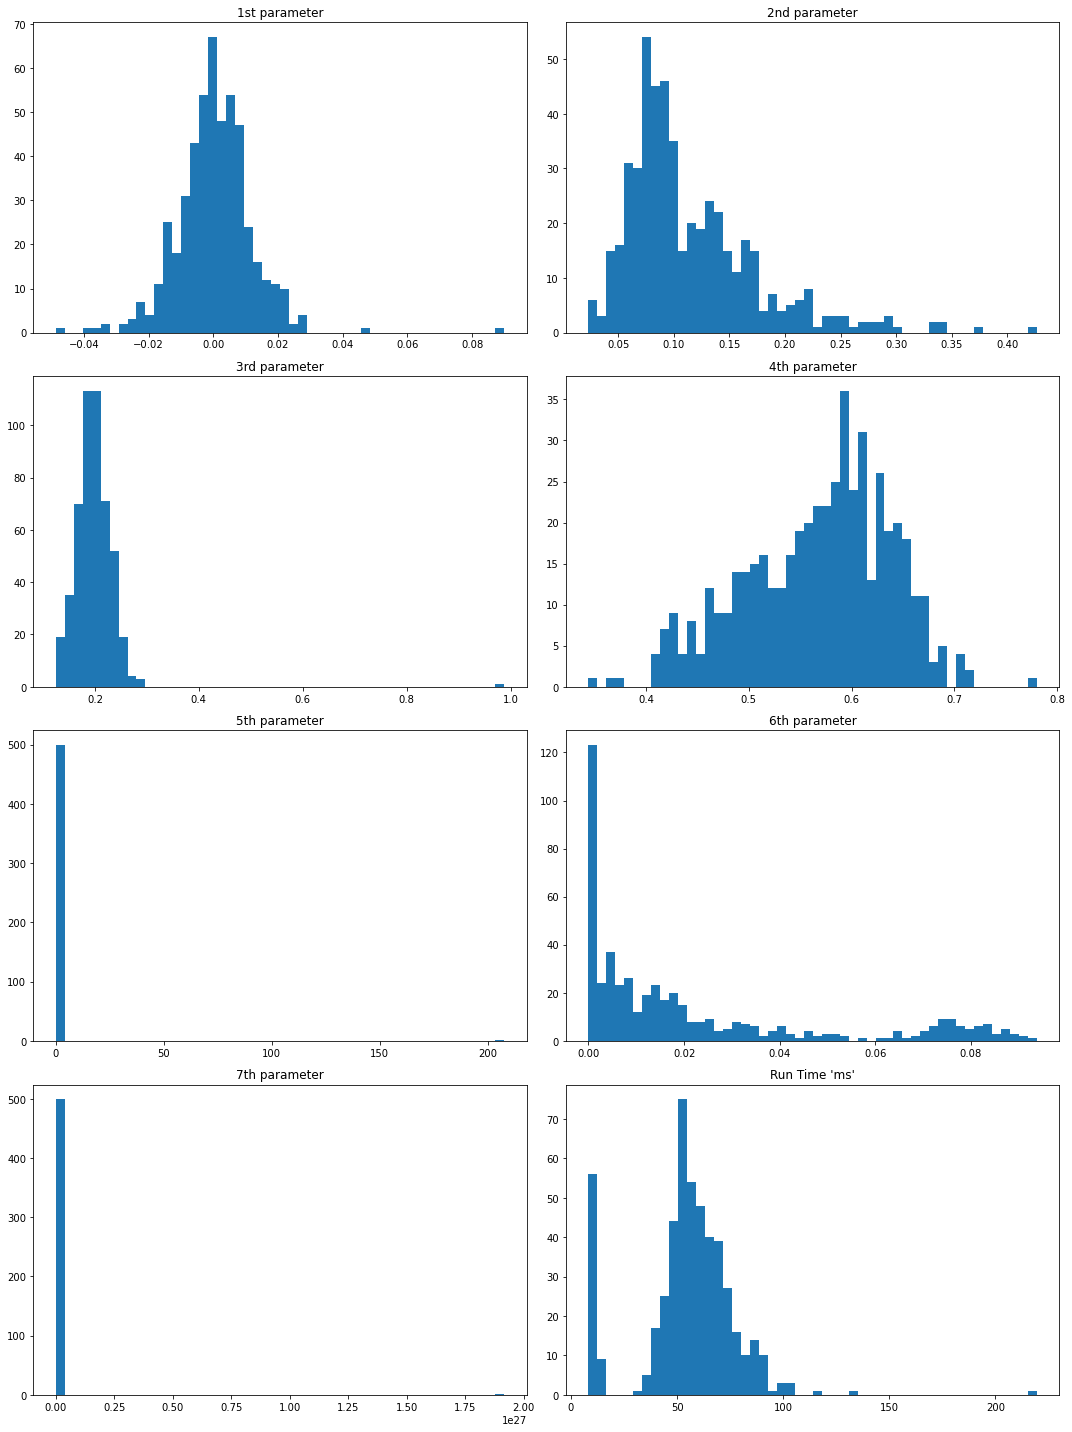

In [9]:
n_bins = 50

fig, ((ax0, ax1), (ax2, ax3), (ax4, ax5), (ax6, ax7)) = plt.subplots(nrows=4, ncols=2)
fig.set_size_inches(15, 20)

ax0.hist(gm_sim['0'], n_bins, density=False, histtype='bar')
ax0.set_title("1st parameter")
ax1.hist(gm_sim['1'], n_bins, density=False, histtype='bar')
ax1.set_title("2nd parameter")
ax2.hist(gm_sim['2'], n_bins, density=False, histtype='bar')
ax2.set_title("3rd parameter")
ax3.hist(gm_sim['3'], n_bins, density=False, histtype='bar')
ax3.set_title("4th parameter")
ax4.hist(gm_sim['4'], n_bins, density=False, histtype='bar')
ax4.set_title("5th parameter")
ax5.hist(gm_sim['5'], n_bins, density=False, histtype='bar')
ax5.set_title("6th parameter")
ax6.hist(gm_sim['6'], n_bins, density=False, histtype='bar')
ax6.set_title("7th parameter")
ax7.hist(gm_sim['runtime'], n_bins, density=False, histtype='bar')
ax7.set_title("Run Time 'ms'")

fig.tight_layout()
plt.show()

In [11]:
for i in range(7):
    print("{} Param's Mean: ".format(i),round(np.mean(gm_sim['{}'.format(i)]), 4), '\t\t\t Std', round(np.std(gm_sim['{}'.format(i)]), 4))
    
print("Run Time's Mean:      ",round(np.mean(gm_sim['runtime']), 4), '\t\t\t Std', round(np.std(gm_sim['runtime']), 4))

0 Param's Mean:  0.0005 			 Std 0.0116
1 Param's Mean:  0.1152 			 Std 0.0597
2 Param's Mean:  0.1981 			 Std 0.0462
3 Param's Mean:  0.568 			 Std 0.0706
4 Param's Mean:  0.8286 			 Std 9.259
5 Param's Mean:  0.0219 			 Std 0.0265
6 Param's Mean:  3.83499200698263e+24 			 Std 8.566723226016288e+25
Run Time's Mean:       54.8831 			 Std 22.5278
